In [1]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Dropout
from keras.initializers import Constant
import re
import gzip
import json
from sklearn.model_selection import train_test_split

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
english_stops = set(stopwords.words('english'))
lemma = nltk.wordnet.WordNetLemmatizer()
sno = nltk.stem.SnowballStemmer('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Va8qhRHr_MCST7_dNxNtI4mtcoFyGYLI' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Va8qhRHr_MCST7_dNxNtI4mtcoFyGYLI" -O Toys_and_Games_5.json.gz && rm -rf /tmp/cookies.txt

--2023-06-06 07:15:10--  https://docs.google.com/uc?export=download&confirm=t&id=1Va8qhRHr_MCST7_dNxNtI4mtcoFyGYLI
Resolving docs.google.com (docs.google.com)... 173.194.194.139, 173.194.194.100, 173.194.194.102, ...
Connecting to docs.google.com (docs.google.com)|173.194.194.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-8g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/898uho48e5d712guki3sddeh57v2v9sn/1686035700000/04268100670184909597/*/1Va8qhRHr_MCST7_dNxNtI4mtcoFyGYLI?e=download&uuid=6cd7329b-b392-41c3-8731-0264283a8cb8 [following]
--2023-06-06 07:15:10--  https://doc-04-8g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/898uho48e5d712guki3sddeh57v2v9sn/1686035700000/04268100670184909597/*/1Va8qhRHr_MCST7_dNxNtI4mtcoFyGYLI?e=download&uuid=6cd7329b-b392-41c3-8731-0264283a8cb8
Resolving doc-04-8g-docs.googleusercontent.com (doc-04-8g-docs.googleusercontent.com)... 108.177.120.

In [3]:
def read_data(n=1000):
    fin = gzip.open('Toys_and_Games_5.json.gz', 'rt', encoding='UTF-8')

    data = {'review':[], 'overall':[]}
    for i in range(n):
        try:
            d = json.loads(fin.readline())
            data['review'].append(d['reviewText'])
            data['overall'].append(int(d['overall']))
        except:
            pass
            
    df = pd.DataFrame(data)

    del data
    del fin
    del d

    x_data = df['review']
    y_data = df['overall']

    x_data = x_data.replace({'<.*?>': ''}, regex=True)
    x_data = x_data.replace({'[/(){}\[\]\|@,;]': ''}, regex=True)
    x_data = x_data.replace({'[^0-9A-Za-z #+_]': ' '}, regex=True)
    x_data = x_data.apply(lambda review: [w for w in review.split() if w not in english_stops])
    x_data = x_data.apply(lambda review: [w.lower() for w in review])
    # x_data = x_data.apply(lambda review: [lemma.lemmatize(w) for w in review])
    x_data = x_data.apply(lambda review: [sno.stem(w) for w in review])


    return x_data, y_data

In [4]:
def get_max_length(x_train):
    review_length = []
    for review in x_train:
        review_length.append(len(review))

    return int(np.ceil(np.mean(review_length)))

def one_hot(y):
    ret = np.zeros((y.size, y.max()))

    ret[np.arange(y.size), y-1] = 1.0
    return ret

In [5]:
X, Y = read_data(2000000)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.05, shuffle=True)

y = one_hot(y_train.values)
y_test = one_hot(y_test.values)

In [6]:
tok = Tokenizer()
tok.fit_on_texts(x_train)
vocab_size = len(tok.word_index)+1
encd_rev = tok.texts_to_sequences(x_train)
encd_rev_test = tok.texts_to_sequences(x_test)
max_len = get_max_length(x_train)
embed_dim=200

In [7]:
x_train_ = pad_sequences(encd_rev, maxlen=max_len, padding='post', truncating='post')
x_test_ = pad_sequences(encd_rev_test, maxlen=max_len, padding='post', truncating='post')

In [11]:
import gensim.downloader as api
word2vec_model = api.load('glove-twitter-200')

[=================================================-] 99.6% 755.4/758.5MB downloaded


In [12]:
embed_matrix=np.zeros(shape=(vocab_size,embed_dim))

for word,i in tok.word_index.items():

    try:
        embed_vector = word2vec_model.get_vector(word)
    except:
        embed_vector = word2vec_model.get_vector('unk')
    
    embed_matrix[i]=embed_vector

In [13]:
model = Sequential()
model.add(Embedding(vocab_size, 200, input_length=max_len, embeddings_initializer=Constant(embed_matrix)))
# model.add(tf.keras.layers.GRU(128, dropout=0.2))
# model.add(Dropout(0.1))
# model.add(tf.keras.layers.LSTM(128))
# model.add(LSTM(LSTM_OUT))
# model.add(Dropout(0.2))

model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout=0.2)))
# model.add(tf.keras.layers.Dense(128, activation='relu'))
# model.add(Dropout(0.25))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
x_train.shape

(1736406,)

In [14]:
h = model.fit(x_train_, y, batch_size=256, epochs=5, validation_split=0.1)


Epoch 1/5
6105/6105 [==============================] - 125s 19ms/step - loss: 0.6763 - accuracy: 0.7495 - val_loss: 0.6403 - val_accuracy: 0.7608
Epoch 2/5
6105/6105 [==============================] - 81s 13ms/step - loss: 0.6330 - accuracy: 0.7634 - val_loss: 0.6225 - val_accuracy: 0.7668
Epoch 3/5
6105/6105 [==============================] - 80s 13ms/step - loss: 0.6174 - accuracy: 0.7686 - val_loss: 0.6147 - val_accuracy: 0.7692
Epoch 4/5
6105/6105 [==============================] - 77s 13ms/step - loss: 0.6069 - accuracy: 0.7722 - val_loss: 0.6089 - val_accuracy: 0.7718
Epoch 5/5
6105/6105 [==============================] - 79s 13ms/step - loss: 0.5989 - accuracy: 0.7749 - val_loss: 0.6048 - val_accuracy: 0.7730


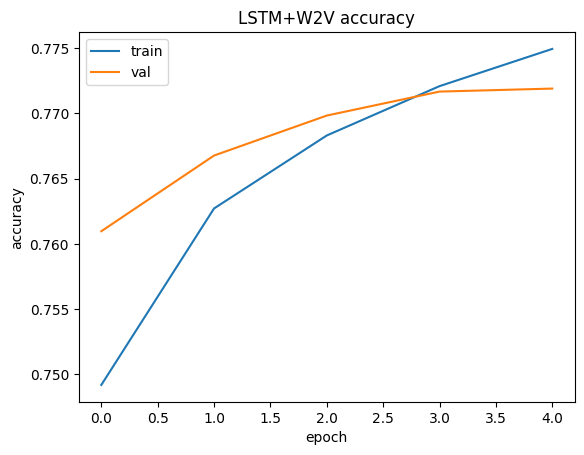

In [13]:
from matplotlib import pyplot as plt
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('LSTM+W2V accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
del model